In [1]:
# Install libraries for data_loader
!pip install pandas
!pip install sklearn
!pip install torchvision
!pip install tqdm
!pip install torchmetrics

In [2]:
# Import DataLoader and corresponding libraries
import pandas
import torchvision.transforms as TT
from torch.utils.data import DataLoader, Dataset, sampler
from sklearn.model_selection import StratifiedKFold
from torchvision import utils
from PIL import Image

In [3]:
# Import libraries for tensors
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
# For fbeta-score
from torchmetrics.functional import fbeta_score

In [5]:
# For model construction
from collections import OrderedDict

In [6]:
# Import tqdm for progress bar construction
import tqdm

In [7]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Datatypes and Devices (from Assignment 2)
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


In [8]:
# Hyper-parameters for K-Fold Cross Validation
N = 5
seed = 42

# Directories for Data
FF1010_Path = './data/'
AudioImage_Path = './image/'

In [9]:
# Call StratifiedKFold object
skf = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=seed
)

In [10]:
# Modify dataframe for K-Fold Cross Validation (birdclef2021)
birdclef_csv = pandas.read_csv(AudioImage_Path + 'metadata.csv')
birdclef_csv.loc[birdclef_csv['label_id'] >= 0,'filepath'] = \
    AudioImage_Path + birdclef_csv.query('label_id >= 0')['primary_label'] + '/' + \
    birdclef_csv.query('label_id >= 0')['filename'] + '.npy'

birdclef_csv = birdclef_csv.dropna()
birdclef_csv = birdclef_csv.reset_index(drop=True)

# Add 'fold' attribute for dataset classification
birdclef_dataframe = birdclef_csv.copy()
for n, (_, nth_groups) in enumerate(
    skf.split(birdclef_dataframe, birdclef_dataframe['label_id'])):
    birdclef_dataframe.loc[nth_groups, 'fold'] = int(n)

In [11]:
# Class for ff1010 dataset
class birdclef(Dataset):
    def __init__(self, dataframe, process='train', labels='label_id'):
        self.dataframe = dataframe
        self.filepaths = dataframe['filepath'].values
        self.labels = dataframe[labels].values
        self.process = process
        
        # Transforms for each train and validation
        self.train_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.RandomHorizontalFlip(p=0.5),
            TT.RandomVerticalFlip(p=0.5),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
        self.val_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
    
    def __getitem__(self, idx):
        source = np.load(self.filepaths[idx])
        
        # Rearrange numpy arrays
        source = source.transpose(1, 2, 0)
        
        # Add RGB dimension
        source = np.stack((np.squeeze(source), ) * 3, -1)
        if len(source.shape) == 3:
            source = np.expand_dims(source, axis=2)
        source = source.transpose(2, 0, 1, 3)
        N, H, W, C = source.shape
        
        # Apply transform
        if self.process == 'train':
            source = torch.stack([self.train_transform(Image.fromarray(x)) for x in source])
        elif self.process == 'valid':
            source = torch.stack([self.val_transform(Image.fromarray(x)) for x in source])
        
        # Select the middle input from slices
        source = source[N // 2]

        return source, torch.tensor(self.labels[idx], dtype=ltype)
    
    def __len__(self):
        return len(self.dataframe)

This function evaluates model.

In [12]:
def evaluate_model(loader, model, beta=1.0):
    print("Checking accuracy score on validation set.")
    # TODO: extend this so that we can print that we evaluate test set.
    num_correct = 0
    num_samples = 0
    log_sum = 0
    fbeta_sum = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float)
            y = y.to(device=device, dtype=torch.long)
            y = torch.squeeze(y, 0)
            scores = model(torch.squeeze(x, 0))
            # scores means classfication class for each class. It should be the tensor with size of (Input size, Number of classes)

            # Checks naive accuracy.
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

            # Checks Log Loss.
            log_loss = F.cross_entropy(scores, y)
            log_sum += log_loss.sum() * preds.size(0)

            # Checks Fbeta-score.
            fbeta = fbeta_score(preds, y, beta=beta)
            fbeta_sum += fbeta * preds.size(0)
            
            # Erase memory caches
            del x, y, scores, log_loss
        
        acc = float(num_correct) / num_samples
        log_score = log_sum / num_samples
        f_score = fbeta_sum / num_samples
        print('\nAccuracy: %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('Log Loss score:\t%.2f' % (log_score))
        print('Fbeta-score (beta=%d): \t%.2f' % (beta , f_score))
    return acc, log_score, f_score

Let's train with model 2.

In [13]:
import os

# Print period for accuracy.
print_period = 100

# Hyper-parameters for training 
birdclef_batch = 32
birdclef_epoch = 10

# Learning Rate.
learning_rate_2 = 0.01

# L2 Regularization Hyperparamter
weight_decay_2 = 0.001

# Beta constant for Fbeta-score.
# If you want to give more weight to precision, use value smaller than 1.0.
# If you want to give more weight to recall, use value larger than 1.0.
beta = 1.0

# Prototype of model 2.
# ResNet50 outputs (Batchsize, 1000) tensor as output, so we reduce them to 397.
class Model2(nn.Module):
    def __init__(self, num_classes=397):
        super().__init__()
        self.resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
        self.relu = nn.ReLU().to(device)
        self.linear = nn.Linear(1000, num_classes, bias=True).to(device)
    
    def forward (self, x):
        x = self.resnet50(x)
        x = self.relu(x)
        x = self.linear(x)
        return x

cur_model = Model2()
print(cur_model)

def checkpoint(model, optimizer, loss, epoch, index):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, './bird_specificator.pt')

def train_model(model, train_loader, val_loader, optimizer, beta=beta, epoch=birdclef_epoch):
    val_losses = []
    train_losses = []
    epoch_losses = []
    log_scores = []
    fbeta_scores = []
    
    loss = 0
    log_score = 0
    saved_epoch = -1
    
    # Load checkpoint
    if os.path.exists('./bird_specificator.pt'):
        ckpt = torch.load('./bird_specificator.pt')
        model.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        epoch_losses = ckpt['loss']
        saved_epoch = ckpt['epoch']
    
    for e in range(epoch):
        if e < saved_epoch:
            continue
        
        if len(val_losses) == 0 and saved_epoch > -1:
            acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
            val_losses.append(acc)
            train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))
            log_scores.append(log_score)
            fbeta_scores.append(fbeta_score)
            
        print(f"Training model 2, epoch {e+1}")
        for index, (source, label) in enumerate(tqdm.tqdm(train_loader)):          
            x = source.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
            y = label.to(device=device, dtype=torch.long)
            y = torch.squeeze(y, 0)

            scores = model(torch.squeeze(x, 0))
            loss = F.cross_entropy(scores, y) # Log loss for our project.

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            # every print_period, print loss.
            if index % print_period == 0:
                print('Iteration %d, loss = %.4f' % (index, loss.item()))
                
            # Erase memory caches
            del source, label, x, y, scores, loss
            
        # every epoch, save the model
        checkpoint(model, optimizer, epoch_losses, e, index)
        
        # Append the score to lists
        acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
        val_losses.append(acc)
        train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))
        log_scores.append(log_score)
        fbeta_scores.append(fbeta_score)

    return model, val_losses, train_losses, log_scores, fbeta_scores

Using cache found in C:\Users\youngrae/.cache\torch\hub\pytorch_vision_v0.10.0


Model2(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [14]:
# Train loop for bird specificator
def bird_train(model, train_dataframe, val_dataframe, test_dataframe):  
    train_data = birdclef(train_dataframe, process='train', labels='label_id')
    val_data = birdclef(val_dataframe, process='valid', labels='label_id')
    test_data = birdclef(test_dataframe, process='valid', labels='label_id')
    
    # Construct data loader for train and validation
    train_loader = DataLoader(train_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(train_dataframe))), 
                             drop_last=True)
    val_loader = DataLoader(val_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(val_dataframe))),
                             drop_last=False)
    test_loader = DataLoader(test_data, batch_size=birdclef_batch,
                              sampler=sampler.SubsetRandomSampler(range(len(test_dataframe))),
                              drop_last=False)
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate_2, momentum=0.5, weight_decay=weight_decay_2)
    trained_model, val_losses, train_losses, log_scores, fbeta_scores = train_model(
        model, train_loader, val_loader, optimizer, beta=beta)
    test_acc, test_log_score, test_fbeta_score = evaluate_model(test_loader, trained_model, beta=beta)
    
    return val_losses, train_losses, log_scores, fbeta_scores, [test_acc, test_log_score, test_fbeta_score]

In [15]:
# Train, Validate and Test for nocall detector
def bird(model, dataframe, val_index, test_index):
    
    # Check that validation fold is not same as test fold
    assert val_index != test_index, \
        'Validation and test should be done on different fold.'
    print('Test set : %d, Validation set : %d' % (test_index, val_index))
    
    train_dataframe = dataframe.query(
        'fold != ' + str(val_index) + ' and fold != ' + str(test_index) 
    ).reset_index(drop=True)
    val_dataframe = dataframe.query(
        'fold == ' + str(val_index) 
    ).reset_index(drop=False)
    test_dataframe = dataframe.query(
        'fold == ' + str(test_index) 
    ).reset_index(drop=False)
    
    val_losses, train_losses, log_scores, fbeta_scores, test_scores = bird_train(
        model, train_dataframe, val_dataframe, test_dataframe)

    return val_losses, train_losses, log_scores, fbeta_scores, test_scores

In [16]:
val_losses, train_losses, log_scores, fbeta_scores, test_scores = \
    bird(cur_model, birdclef_dataframe, 1, 0)
del cur_model

# for i in range(2, 5):
#     cur_model = Model2()
#     cv_losses, ctr_losses, cl_scores, cf_scores, cte_scores = nocall(cur_model, birdclef_dataframe, i, 0)
#     val_losses = torch.mean(torch.stack((torch.tensor(val_losses), torch.tensor(cv_losses))), dim=0)
#     train_losses = torch.mean(torch.stack((torch.tensor(train_losses), torch.tensor(ctr_losses))), dim=0)
#     log_scores = torch.mean(torch.stack((torch.tensor(log_scores), torch.tensor(cl_scores))), dim=0)
#     fbeta_scores = torch.mean(torch.stack((torch.tensor(fbeta_scores), torch.tensor(cf_scores))), dim=0)
#     for j in range(len(test_scores)):
#         test_scores[j] = torch.mean(torch.stack((torch.tensor(test_scores[j]), torch.tensor(cte_scores[j]))), dim=0)

Test set : 0, Validation set : 1
Training model 2, epoch 1


  0%|                                                                               | 1/1178 [00:03<1:08:07,  3.47s/it]

Iteration 0, loss = 6.3199


  9%|██████▊                                                                        | 101/1178 [00:57<09:31,  1.88it/s]

Iteration 100, loss = 5.7778


 17%|█████████████▍                                                                 | 201/1178 [01:48<08:32,  1.91it/s]

Iteration 200, loss = 5.6781


 26%|████████████████████▏                                                          | 301/1178 [02:40<07:31,  1.94it/s]

Iteration 300, loss = 5.3022


 34%|██████████████████████████▉                                                    | 401/1178 [03:36<07:07,  1.82it/s]

Iteration 400, loss = 5.2754


 43%|█████████████████████████████████▌                                             | 501/1178 [04:31<06:12,  1.82it/s]

Iteration 500, loss = 5.1734


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:25<04:58,  1.93it/s]

Iteration 600, loss = 3.8872


 60%|███████████████████████████████████████████████                                | 701/1178 [06:22<04:36,  1.72it/s]

Iteration 700, loss = 4.3826


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [07:18<03:15,  1.93it/s]

Iteration 800, loss = 3.9351


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [08:13<02:44,  1.68it/s]

Iteration 900, loss = 4.5624


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [09:12<01:40,  1.77it/s]

Iteration 1000, loss = 3.3420


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [10:11<00:46,  1.66it/s]

Iteration 1100, loss = 3.9492


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [11:00<00:00,  1.78it/s]


Checking accuracy score on validation set.

Accuracy: 3262 / 12575 correct (25.94)
Log Loss score:	3.70
Fbeta-score (beta=1): 	0.26
Training model 2, epoch 2


  0%|                                                                                 | 1/1178 [00:00<12:10,  1.61it/s]

Iteration 0, loss = 3.5935


  9%|██████▊                                                                        | 101/1178 [00:57<10:05,  1.78it/s]

Iteration 100, loss = 3.8866


 17%|█████████████▍                                                                 | 201/1178 [01:53<08:38,  1.89it/s]

Iteration 200, loss = 3.5591


 26%|████████████████████▏                                                          | 301/1178 [02:50<08:42,  1.68it/s]

Iteration 300, loss = 3.5999


 34%|██████████████████████████▉                                                    | 401/1178 [03:47<07:29,  1.73it/s]

Iteration 400, loss = 4.6657


 43%|█████████████████████████████████▌                                             | 501/1178 [04:43<06:16,  1.80it/s]

Iteration 500, loss = 4.0705


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:40<05:05,  1.89it/s]

Iteration 600, loss = 3.9812


 60%|███████████████████████████████████████████████                                | 701/1178 [06:38<04:25,  1.80it/s]

Iteration 700, loss = 4.3520


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [07:36<03:27,  1.82it/s]

Iteration 800, loss = 3.1532


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [08:34<02:49,  1.63it/s]

Iteration 900, loss = 3.9803


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [09:33<01:39,  1.77it/s]

Iteration 1000, loss = 4.2416


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [10:32<00:45,  1.70it/s]

Iteration 1100, loss = 4.4822


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [11:18<00:00,  1.74it/s]


Checking accuracy score on validation set.

Accuracy: 3997 / 12575 correct (31.79)
Log Loss score:	3.33
Fbeta-score (beta=1): 	0.32
Training model 2, epoch 3


  0%|                                                                                 | 1/1178 [00:00<11:22,  1.72it/s]

Iteration 0, loss = 3.3347


  9%|██████▊                                                                        | 101/1178 [00:54<09:53,  1.81it/s]

Iteration 100, loss = 3.0910


 17%|█████████████▍                                                                 | 201/1178 [01:50<09:29,  1.72it/s]

Iteration 200, loss = 2.5270


 26%|████████████████████▏                                                          | 301/1178 [02:45<07:53,  1.85it/s]

Iteration 300, loss = 3.7072


 34%|██████████████████████████▉                                                    | 401/1178 [03:42<06:53,  1.88it/s]

Iteration 400, loss = 3.7063


 43%|█████████████████████████████████▌                                             | 501/1178 [04:37<05:43,  1.97it/s]

Iteration 500, loss = 3.1929


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:33<05:36,  1.72it/s]

Iteration 600, loss = 2.4778


 60%|███████████████████████████████████████████████                                | 701/1178 [06:28<04:27,  1.78it/s]

Iteration 700, loss = 2.4050


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [07:25<03:20,  1.88it/s]

Iteration 800, loss = 2.5903


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [08:22<02:32,  1.82it/s]

Iteration 900, loss = 2.8618


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [09:20<01:44,  1.69it/s]

Iteration 1000, loss = 3.1068


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [10:21<00:49,  1.55it/s]

Iteration 1100, loss = 3.4375


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [11:08<00:00,  1.76it/s]


Checking accuracy score on validation set.

Accuracy: 4615 / 12575 correct (36.70)
Log Loss score:	3.05
Fbeta-score (beta=1): 	0.37
Training model 2, epoch 4


  0%|                                                                                 | 1/1178 [00:00<13:28,  1.46it/s]

Iteration 0, loss = 2.3691


  9%|██████▊                                                                        | 101/1178 [00:59<10:25,  1.72it/s]

Iteration 100, loss = 2.4789


 17%|█████████████▍                                                                 | 201/1178 [01:56<08:50,  1.84it/s]

Iteration 200, loss = 2.3384


 26%|████████████████████▏                                                          | 301/1178 [02:50<07:53,  1.85it/s]

Iteration 300, loss = 2.5881


 34%|██████████████████████████▉                                                    | 401/1178 [03:47<08:18,  1.56it/s]

Iteration 400, loss = 3.1215


 43%|█████████████████████████████████▌                                             | 501/1178 [04:42<06:04,  1.86it/s]

Iteration 500, loss = 2.6094


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:37<04:57,  1.94it/s]

Iteration 600, loss = 3.1969


 60%|███████████████████████████████████████████████                                | 701/1178 [06:35<04:36,  1.72it/s]

Iteration 700, loss = 3.0685


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [07:33<03:24,  1.84it/s]

Iteration 800, loss = 2.5915


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [08:31<02:47,  1.65it/s]

Iteration 900, loss = 2.8691


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [09:30<01:47,  1.64it/s]

Iteration 1000, loss = 3.9011


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [10:32<00:51,  1.50it/s]

Iteration 1100, loss = 2.0432


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [11:21<00:00,  1.73it/s]


Checking accuracy score on validation set.

Accuracy: 5073 / 12575 correct (40.34)
Log Loss score:	2.85
Fbeta-score (beta=1): 	0.40
Training model 2, epoch 5


  0%|                                                                                 | 1/1178 [00:00<14:05,  1.39it/s]

Iteration 0, loss = 2.0628


  9%|██████▊                                                                        | 101/1178 [00:57<09:28,  1.90it/s]

Iteration 100, loss = 2.8338


 17%|█████████████▍                                                                 | 201/1178 [01:53<09:22,  1.74it/s]

Iteration 200, loss = 2.8152


 26%|████████████████████▏                                                          | 301/1178 [02:49<08:00,  1.82it/s]

Iteration 300, loss = 2.7760


 34%|██████████████████████████▉                                                    | 401/1178 [03:44<06:52,  1.88it/s]

Iteration 400, loss = 2.5594


 43%|█████████████████████████████████▌                                             | 501/1178 [04:39<05:52,  1.92it/s]

Iteration 500, loss = 2.0499


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:36<05:33,  1.73it/s]

Iteration 600, loss = 2.3470


 60%|███████████████████████████████████████████████                                | 701/1178 [06:34<04:26,  1.79it/s]

Iteration 700, loss = 2.8306


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [07:32<03:47,  1.66it/s]

Iteration 800, loss = 2.0555


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [08:30<02:47,  1.65it/s]

Iteration 900, loss = 2.9512


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [09:29<01:39,  1.77it/s]

Iteration 1000, loss = 2.4530


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [10:29<00:47,  1.63it/s]

Iteration 1100, loss = 2.3328


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [11:15<00:00,  1.74it/s]


Checking accuracy score on validation set.

Accuracy: 4952 / 12575 correct (39.38)
Log Loss score:	2.93
Fbeta-score (beta=1): 	0.39
Training model 2, epoch 6


  0%|                                                                                 | 1/1178 [00:00<11:35,  1.69it/s]

Iteration 0, loss = 2.9767


  9%|██████▊                                                                        | 101/1178 [00:54<10:07,  1.77it/s]

Iteration 100, loss = 2.3720


 17%|█████████████▍                                                                 | 201/1178 [01:49<08:55,  1.83it/s]

Iteration 200, loss = 2.5434


 26%|████████████████████▏                                                          | 301/1178 [02:43<08:28,  1.72it/s]

Iteration 300, loss = 1.9445


 34%|██████████████████████████▉                                                    | 401/1178 [03:39<07:12,  1.80it/s]

Iteration 400, loss = 1.8803


 43%|█████████████████████████████████▌                                             | 501/1178 [04:35<05:50,  1.93it/s]

Iteration 500, loss = 2.6017


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:31<05:06,  1.88it/s]

Iteration 600, loss = 1.7201


 60%|███████████████████████████████████████████████                                | 701/1178 [06:28<04:39,  1.71it/s]

Iteration 700, loss = 2.1841


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [07:24<04:03,  1.55it/s]

Iteration 800, loss = 2.3329


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [08:21<02:26,  1.89it/s]

Iteration 900, loss = 2.7443


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [09:17<01:38,  1.79it/s]

Iteration 1000, loss = 2.1473


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [10:17<00:46,  1.65it/s]

Iteration 1100, loss = 2.1456


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [11:05<00:00,  1.77it/s]


Checking accuracy score on validation set.

Accuracy: 5510 / 12575 correct (43.82)
Log Loss score:	2.73
Fbeta-score (beta=1): 	0.44
Training model 2, epoch 7


  0%|                                                                                 | 1/1178 [00:00<11:05,  1.77it/s]

Iteration 0, loss = 1.5126


  9%|██████▊                                                                        | 101/1178 [00:55<09:35,  1.87it/s]

Iteration 100, loss = 1.9216


 17%|█████████████▍                                                                 | 201/1178 [01:52<09:54,  1.64it/s]

Iteration 200, loss = 2.1093


 26%|████████████████████▏                                                          | 301/1178 [02:49<08:04,  1.81it/s]

Iteration 300, loss = 2.4027


 34%|██████████████████████████▉                                                    | 401/1178 [03:44<07:00,  1.85it/s]

Iteration 400, loss = 2.6320


 43%|█████████████████████████████████▌                                             | 501/1178 [04:42<06:31,  1.73it/s]

Iteration 500, loss = 3.1155


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:45<06:24,  1.50it/s]

Iteration 600, loss = 2.6661


 60%|███████████████████████████████████████████████                                | 701/1178 [06:48<04:55,  1.62it/s]

Iteration 700, loss = 2.3144


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [07:51<04:11,  1.50it/s]

Iteration 800, loss = 2.0440


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [08:58<03:13,  1.43it/s]

Iteration 900, loss = 2.8599


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [10:07<02:09,  1.36it/s]

Iteration 1000, loss = 1.6780


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [11:18<00:54,  1.42it/s]

Iteration 1100, loss = 2.4482


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [12:12<00:00,  1.61it/s]


Checking accuracy score on validation set.

Accuracy: 6064 / 12575 correct (48.22)
Log Loss score:	2.53
Fbeta-score (beta=1): 	0.48
Training model 2, epoch 8


  0%|                                                                                 | 1/1178 [00:00<14:32,  1.35it/s]

Iteration 0, loss = 1.8752


  9%|██████▊                                                                        | 101/1178 [01:01<11:04,  1.62it/s]

Iteration 100, loss = 1.6556


 17%|█████████████▍                                                                 | 201/1178 [02:01<09:56,  1.64it/s]

Iteration 200, loss = 1.8857


 26%|████████████████████▏                                                          | 301/1178 [03:03<08:59,  1.62it/s]

Iteration 300, loss = 2.3208


 34%|██████████████████████████▉                                                    | 401/1178 [04:02<07:46,  1.67it/s]

Iteration 400, loss = 2.1672


 43%|█████████████████████████████████▌                                             | 501/1178 [05:03<07:07,  1.58it/s]

Iteration 500, loss = 1.5836


 51%|████████████████████████████████████████▎                                      | 601/1178 [06:06<06:23,  1.50it/s]

Iteration 600, loss = 2.1209


 60%|███████████████████████████████████████████████                                | 701/1178 [07:07<04:32,  1.75it/s]

Iteration 700, loss = 2.4959


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [08:10<04:05,  1.53it/s]

Iteration 800, loss = 1.8277


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [09:14<02:55,  1.58it/s]

Iteration 900, loss = 2.0500


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [10:18<01:48,  1.64it/s]

Iteration 1000, loss = 1.8607


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [11:27<01:01,  1.26it/s]

Iteration 1100, loss = 1.2467


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [12:18<00:00,  1.60it/s]


Checking accuracy score on validation set.

Accuracy: 5984 / 12575 correct (47.59)
Log Loss score:	2.63
Fbeta-score (beta=1): 	0.48
Training model 2, epoch 9


  0%|                                                                                 | 1/1178 [00:00<14:15,  1.38it/s]

Iteration 0, loss = 1.3866


  9%|██████▊                                                                        | 101/1178 [01:00<10:14,  1.75it/s]

Iteration 100, loss = 2.6012


 17%|█████████████▍                                                                 | 201/1178 [02:00<09:38,  1.69it/s]

Iteration 200, loss = 1.4163


 26%|████████████████████▏                                                          | 301/1178 [03:01<09:14,  1.58it/s]

Iteration 300, loss = 2.0112


 34%|██████████████████████████▉                                                    | 401/1178 [04:01<08:01,  1.61it/s]

Iteration 400, loss = 2.4580


 43%|█████████████████████████████████▌                                             | 501/1178 [05:01<07:01,  1.60it/s]

Iteration 500, loss = 2.2332


 51%|████████████████████████████████████████▎                                      | 601/1178 [06:03<06:00,  1.60it/s]

Iteration 600, loss = 1.8437


 60%|███████████████████████████████████████████████                                | 701/1178 [07:03<04:35,  1.73it/s]

Iteration 700, loss = 2.1127


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [08:03<03:42,  1.70it/s]

Iteration 800, loss = 1.7433


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [09:04<02:46,  1.66it/s]

Iteration 900, loss = 2.1349


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [10:05<01:47,  1.64it/s]

Iteration 1000, loss = 2.5055


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [11:02<00:44,  1.72it/s]

Iteration 1100, loss = 1.5691


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [11:46<00:00,  1.67it/s]


Checking accuracy score on validation set.

Accuracy: 6168 / 12575 correct (49.05)
Log Loss score:	2.56
Fbeta-score (beta=1): 	0.49
Training model 2, epoch 10


  0%|                                                                                 | 1/1178 [00:00<13:13,  1.48it/s]

Iteration 0, loss = 1.0519


  9%|██████▊                                                                        | 101/1178 [00:54<10:09,  1.77it/s]

Iteration 100, loss = 1.3988


 17%|█████████████▍                                                                 | 201/1178 [01:48<09:25,  1.73it/s]

Iteration 200, loss = 1.1464


 26%|████████████████████▏                                                          | 301/1178 [02:41<07:34,  1.93it/s]

Iteration 300, loss = 1.5541


 34%|██████████████████████████▉                                                    | 401/1178 [03:35<06:06,  2.12it/s]

Iteration 400, loss = 2.3573


 43%|█████████████████████████████████▌                                             | 501/1178 [04:28<05:59,  1.88it/s]

Iteration 500, loss = 1.6741


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:21<05:05,  1.89it/s]

Iteration 600, loss = 1.7359


 60%|███████████████████████████████████████████████                                | 701/1178 [06:15<04:29,  1.77it/s]

Iteration 700, loss = 1.3961


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [07:09<03:30,  1.79it/s]

Iteration 800, loss = 2.0864


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [08:04<02:26,  1.89it/s]

Iteration 900, loss = 1.8657


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:57<01:38,  1.79it/s]

Iteration 1000, loss = 2.1645


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:52<00:41,  1.85it/s]

Iteration 1100, loss = 1.7591


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:35<00:00,  1.86it/s]


Checking accuracy score on validation set.

Accuracy: 6023 / 12575 correct (47.90)
Log Loss score:	2.62
Fbeta-score (beta=1): 	0.48
Checking accuracy score on validation set.

Accuracy: 6105 / 12575 correct (48.55)
Log Loss score:	2.59
Fbeta-score (beta=1): 	0.49


Text(0.5, 1.0, 'Train Loss Curve of Nocall Detector')

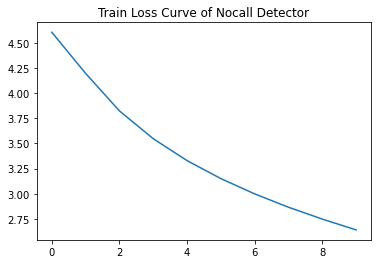

In [17]:
import matplotlib.pyplot as plt

train_losses = torch.tensor(train_losses, device = 'cpu')
plt.plot(np.arange(len(train_losses)), train_losses)
plt.title('Train Loss Curve of Nocall Detector')

Text(0.5, 1.0, 'Validation Accuracy Curve of Nocall Detector')

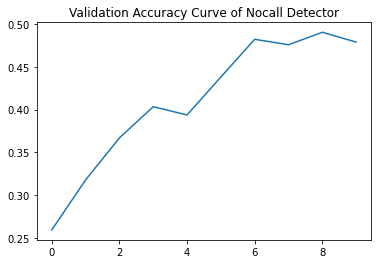

In [18]:
val_losses = torch.tensor(val_losses, device = 'cpu')
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Validation Accuracy Curve of Nocall Detector')

Text(0.5, 1.0, 'Log-score Curve of Nocall Detector')

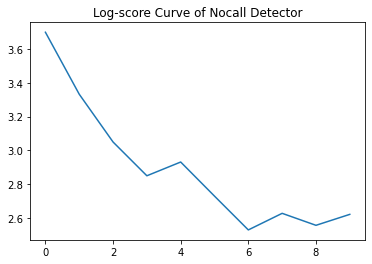

In [19]:
log_scores = torch.tensor(log_scores, device = 'cpu')
plt.plot(np.arange(len(log_scores)), log_scores)
plt.title('Log-score Curve of Nocall Detector')

Text(0.5, 1.0, 'F-beta score Curve of Nocall Detector')

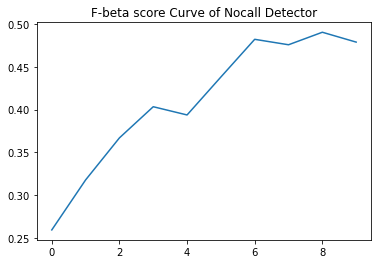

In [20]:
fbeta_scores = torch.tensor(fbeta_scores, device = 'cpu')
plt.plot(np.arange(len(fbeta_scores)), fbeta_scores)
plt.title('F-beta score Curve of Nocall Detector')

In [21]:
print('\nAccuracy: %.2f' % (100 * test_scores[0]))
print('Log Loss score:\t%.2f' % (test_scores[1]))
print('Fbeta-score (beta=1.0): \t%.2f' % (test_scores[2]))


Accuracy: 48.55
Log Loss score:	2.59
Fbeta-score (beta=1.0): 	0.49
